In [1]:
#Holaaaaaaaaaaaaaaaaaa

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   430k      0  0:00:02  0:00:02 --:--:--  431k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [3]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


##**2.2 Tratamiento de Datos**

In [ ]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------


In [ ]:
# Confirmamos que realmente no haya valores nulos en los dataframes
df_movies_null = df_movies[df_movies.isnull().any(axis=1)]
print(df_movies_null) #No hay valores nulos
df_ratings_null = df_ratings[df_ratings.isnull().any(axis=1)]
print(df_ratings_null) #No hay valores nulos

Empty DataFrame
Columns: [movieId, title, genres]
Index: []
Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


In [ ]:
# Confirmamos si hay valores duplicados
df_movies['movieId'].drop_duplicates().info() #No hay duplicados

<class 'pandas.core.series.Series'>
Index: 9742 entries, 0 to 9741
Series name: movieId
Non-Null Count  Dtype
--------------  -----
9742 non-null   int64
dtypes: int64(1)
memory usage: 152.2 KB


In [ ]:
df_ratings[['movieId','userId']].drop_duplicates().info() #No hay duplicados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   movieId  100836 non-null  int64
 1   userId   100836 non-null  int64
dtypes: int64(2)
memory usage: 1.5 MB


In [ ]:
# Creación de columna content para hacer el string de los géneros
df_movies['content'] = df_movies['genres'].str.split('|') # Separamos los generos
df_movies['content'] = df_movies['content'].apply(lambda x: ' '.join(x)) # Los volvemos a unir pero con una separación
print('Tipo de dato de "content"')
print(type(df_movies['content']))
print('Tipo de dato de los registros de "content"')
print(type(df_movies['content'][0]))
df_movies.head()

Tipo de dato de "content"
<class 'pandas.core.series.Series'>
Tipo de dato de los registros de "content"
<class 'str'>


,movieId,title,genres,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,Comedy


In [ ]:
# Creación de columna genres_set para hacer el conjunto de géneros
df_movies['genres_set'] = df_movies['genres'].str.split('|') # Separamos los generos
df_movies['genres_set'] = df_movies['genres_set'].apply(lambda x: set(x)) # Los volvemos a unir pero como un set()
print('Tipo de dato de "genres_set"')
print(type(df_movies['genres_set']))
print('Tipo de dato de los registros de "genres_set"')
print(type(df_movies['genres_set'][0]))
df_movies.head()

Tipo de dato de "genres_set"
<class 'pandas.core.series.Series'>
Tipo de dato de los registros de "genres_set"
<class 'set'>


,movieId,title,genres,content,genres_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Children, Animation, Comedy, Fantasy}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Adventure, Children, Fantasy}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Drama, Romance, Comedy}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [ ]:
# Cambio del tipo de dato en el campo timestamp en df_ratings
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s') # Convertimos a formato de fecha
print('Tipo de dato de "timestamp"')
print(type(df_ratings['timestamp'][0]))
df_ratings.head()

Tipo de dato de "timestamp"
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


In [ ]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movieId     9742 non-null   int64 
 1   title       9742 non-null   object
 2   genres      9742 non-null   object
 3   content     9742 non-null   object
 4   genres_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB
None
-------------


In [ ]:
df_movies.head()

,movieId,title,genres,content,genres_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"{Adventure, Children, Animation, Comedy, Fantasy}"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"{Adventure, Children, Fantasy}"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"{Drama, Romance, Comedy}"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,{Comedy}


In [ ]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30 18:45:03
1,1,3,4.00,2000-07-30 18:20:47
2,1,6,4.00,2000-07-30 18:37:04
3,1,47,5.00,2000-07-30 19:03:35
4,1,50,5.00,2000-07-30 18:48:51


##**2.3 Análisis Exploratorio (EDA)**

In [ ]:
df_movies.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


**Boxplot de la cantidad de géneros por película**

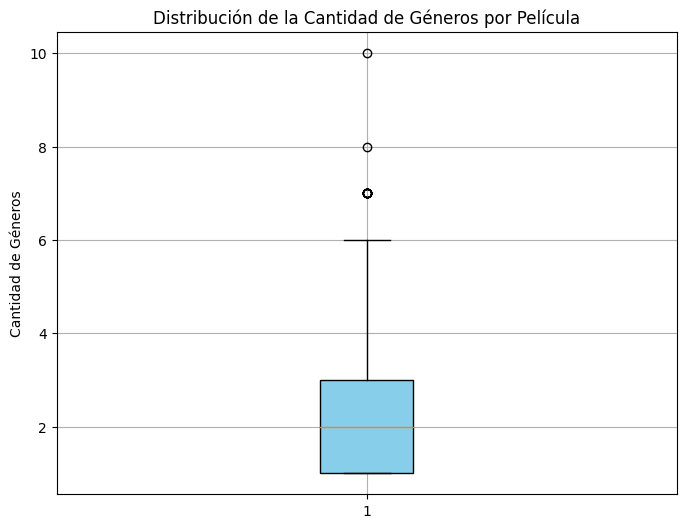

In [ ]:
df_movies['num_genres'] = df_movies['genres'].apply(lambda x: len(x.split('|')))

plt.figure(figsize=(8, 6))
plt.boxplot(df_movies['num_genres'], patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Distribución de la Cantidad de Géneros por Película')
plt.ylabel('Cantidad de Géneros')
plt.grid(True)
plt.show()

In [ ]:
df_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469248
min,1.00,1.00,0.50,1996-03-29 18:36:55
25%,177.00,1199.00,3.00,2002-04-18 09:57:46
50%,325.00,2991.00,3.50,2007-08-02 20:31:02
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000
max,610.00,193609.00,5.00,2018-09-24 14:27:30
std,182.62,35530.99,1.04,NaN


**Histograma de las calificaciones (rating)**

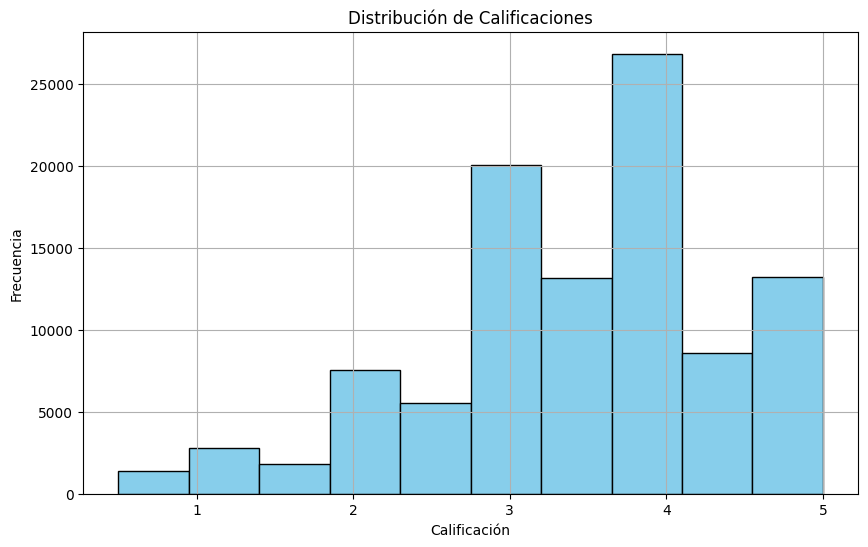

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_ratings['rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribución de Calificaciones')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


**Histograma del número de calificaciones por película**

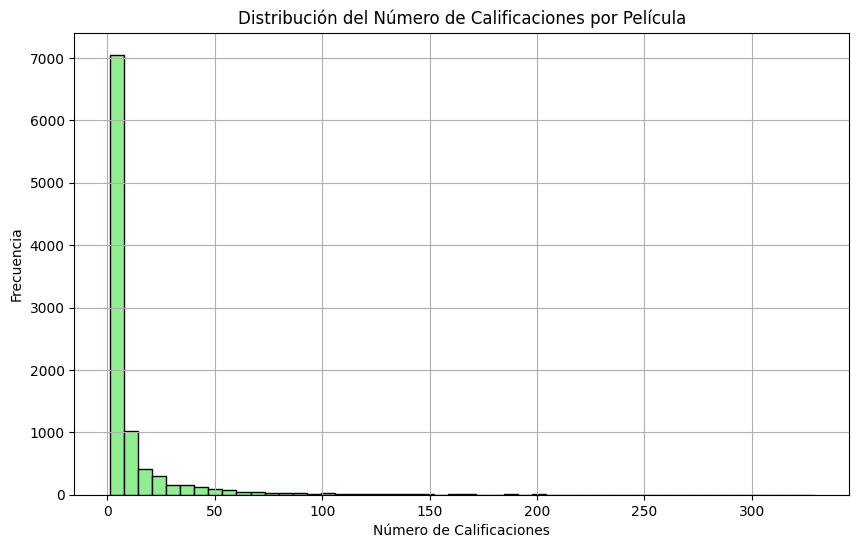

In [ ]:
ratings_per_movie = df_ratings.groupby('movieId').size()

plt.figure(figsize=(10, 6))
plt.hist(ratings_per_movie, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución del Número de Calificaciones por Película')
plt.xlabel('Número de Calificaciones')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [ ]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')

In [ ]:
df_final.describe()

,userId,movieId,rating,timestamp,num_genres
count,100836.00,100836.00,100836.00,100836,100836.00
mean,326.13,19435.30,3.50,2008-03-19 17:01:27.368469504,2.72
min,1.00,1.00,0.50,1996-03-29 18:36:55,1.00
25%,177.00,1199.00,3.00,2002-04-18 09:57:46,2.00
50%,325.00,2991.00,3.50,2007-08-02 20:31:02,3.00
75%,477.00,8122.00,4.00,2015-07-04 07:15:44.500000,3.00
max,610.00,193609.00,5.00,2018-09-24 14:27:30,10.00
std,182.62,35530.99,1.04,NaN,1.19


#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

In [ ]:
#@title
def recomendacion_populares():
  #Tu código aquí
  return top_10_movies

In [ ]:
recomendacion_populares()

NameError: name 'top_10_movies' is not defined

##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**

In [ ]:
#@title
def recomendacion_jaccard(movie_id, df_movies, n_recommendations=10):
    #Tu código aquí
    return recommendations

In [ ]:
recomendaciones = recomendacion_jaccard(1, df_movies, n_recommendations=10)
recomendaciones

###**3.2.2 Similitud de Coseno con TF-IDF**

In [ ]:
#@title
def recomendacion_tf_idf(movie_id, df_movies, cosine_sim, n_recommendations=10):
    #Tu código aquí
    return df_movies

In [ ]:
recomendaciones = recomendacion_tf_idf(58559, df_movies, cosine_sim, n_recommendations=10)
recomendaciones

##**3.3 Recomendación Collaborative Filtering**

In [ ]:
#@title
def recomendacion_knn(usuario_id_o_ratings, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
  #Tu código aquí
  return recommendations


In [ ]:
#usuario = 15
usuario = pd.Series({
    356: 4,
    58559: 5
})

recomendaciones = recomendacion_knn(usuario, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model)
recomendaciones